   특성 변수: 18개
   타겟 변수: 발전량(kWh)
   데이터 포인트: 431,494개
   훈련 데이터: 345,195개
   테스트 데이터: 86,299개

[INFO] 학습/테스트 데이터 분할 완료.

[INFO] 최적 파라미터 직접 적용: {'bootstrap_type': 'Bernoulli', 'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
   모델 성능:
     RMSE: 333.36
     R²: 0.7092
     MAE: 230.54
     오차 중앙값: 155.83

중요 특성:
    1. 풍속(m/s)_cubed: 18.0433
    2. 연식(년): 11.3943
    3. 블레이드: 8.4474
    4. 설비용량(MW): 8.1056
    5. 현지기압(hPa): 7.8848
    6. 풍향_sin: 7.3092
    7. 기온(°C): 5.4418
    8. 풍향_cos: 4.9895
    9. 월_cos: 4.8939
   10. 월_sin: 4.7384
   11. 습도(%): 4.5754
   12. 시간_cos: 2.8905
   13. air_density: 2.4589
   14. 이슬점온도(°C): 2.3286
   15. absolute_humidity: 2.1907
   16. 시간_sin: 2.0425
   17. 증기압(hPa): 1.5720
   18. 계절_encoded: 0.6932
   모델 성능:
     RMSE: 333.36
     R²: 0.7092
     MAE: 230.54
     오차 중앙값: 155.83

중요 특성:
    1. 풍속(m/s)_cubed: 18.0433
    2. 연식(년): 11.3943
    3. 블레이드: 8.4474
    4. 설비용량(MW): 8.1056
    5. 현지기압(hPa): 7.8848
    6. 풍향_sin: 7.3092
  

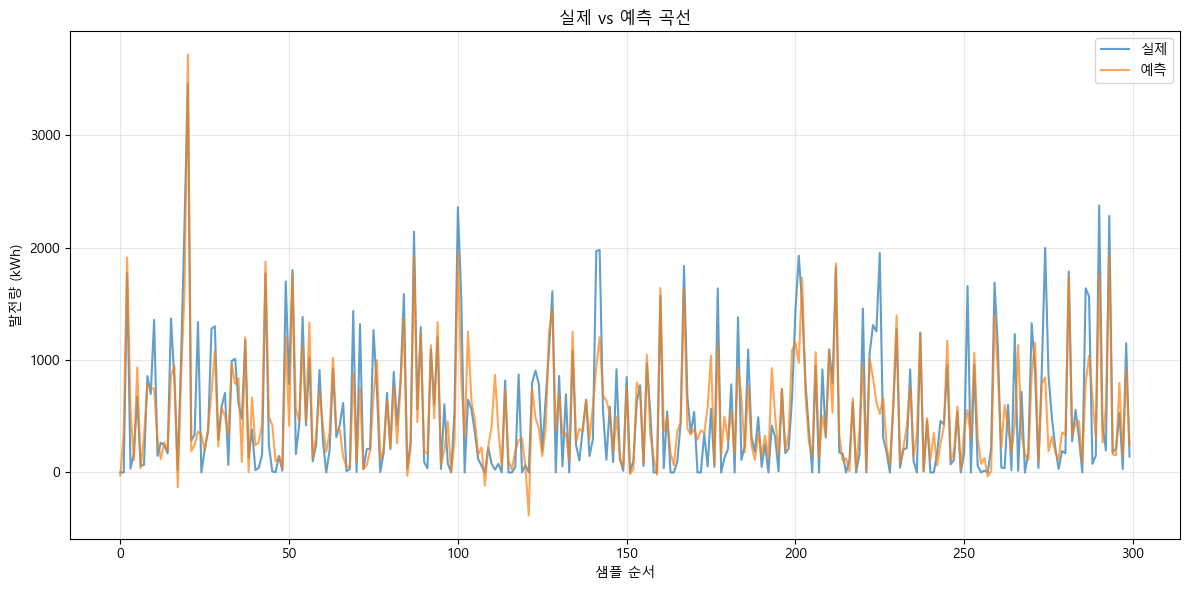

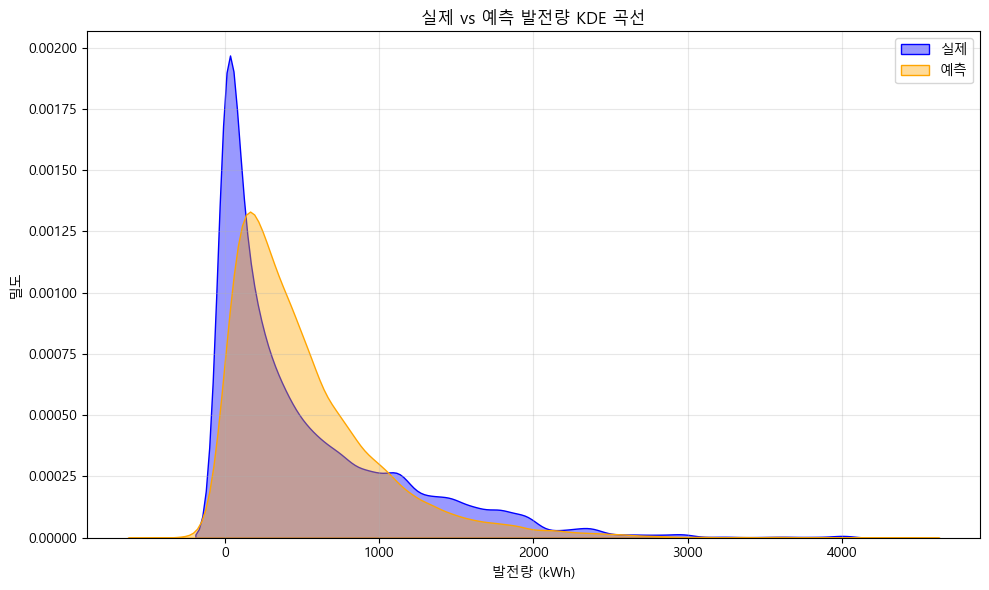

In [ ]:
# 1. 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split #, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
df = pd.read_csv('파생변수추가_기상과풍력.csv')

# 2. 데이터 전처리
categorical_features = ['계절']
label_encoders = {}
for feature in categorical_features:
    if feature in df.columns:
        le = LabelEncoder()
        df[f'{feature}_encoded'] = le.fit_transform(df[feature])
        label_encoders[feature] = le

# 결측값 제거
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    df = df.dropna()
else:
    pass

# 풍속 세제곱 컬럼 추가
if '풍속(m/s)' in df.columns:
    df['풍속(m/s)_cubed'] = df['풍속(m/s)'] ** 3

# 3. 특성 및 타겟 변수 설정
target = '발전량(kWh)'
features = [
    '설비용량(MW)', '연식(년)', '기온(°C)', '풍속(m/s)_cubed', '습도(%)',
    '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)',
    '풍향_sin', '풍향_cos', '시간_sin', '시간_cos', '월_sin', '월_cos',
    '블레이드', 'air_density', 'absolute_humidity',
    '계절_encoded'
]
available_features = [col for col in features if col in df.columns]
X = df[available_features]
y = df[target]

print(f"   특성 변수: {len(available_features)}개")
print(f"   타겟 변수: {target}")
print(f"   데이터 포인트: {len(X):,}개")

# 4. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"   훈련 데이터: {X_train.shape[0]:,}개")
print(f"   테스트 데이터: {X_test.shape[0]:,}개")
print("\n[INFO] 학습/테스트 데이터 분할 완료.")

# 5. 하이퍼파라미터 튜닝 (주석처리)
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'iterations': [400, 600, 800, 1000],
#     'learning_rate': [0.05, 0.07, 0.1],
#     'depth': [6, 8, 10],
#     'l2_leaf_reg': [1, 3, 5],
#     'bootstrap_type': ['Bayesian', 'Bernoulli']
# }
# catboost_model = CatBoostRegressor(loss_function='RMSE', random_seed=42, verbose=0)
# grid_search = GridSearchCV(
#     catboost_model,
#     param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print(f"   최적 파라미터: {best_params}")
# print(f"   최적 CV 점수: {-grid_search.best_score_:.2f}")

# 6. 최적 파라미터 직접 적용
best_params = {
    'bootstrap_type': 'Bernoulli',
    'depth': 10,
    'iterations': 1000,
    'l2_leaf_reg': 1,
    'learning_rate': 0.1
}
print(f"\n[INFO] 최적 파라미터 직접 적용: {best_params}")
best_model = CatBoostRegressor(
    **best_params,
    loss_function='RMSE',
    random_seed=42,
    verbose=0,
    task_type='GPU',
    devices='0'
)
best_model.fit(X_train, y_train)

# 7. 예측 및 평가
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_error = np.median(np.abs(y_test - y_pred))

print(f"   모델 성능:")
print(f"     RMSE: {rmse:.2f}")
print(f"     R²: {r2:.4f}")
print(f"     MAE: {mae:.2f}")
print(f"     오차 중앙값: {median_error:.2f}")

# Feature Importance
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importance}).sort_values('importance', ascending=False)
print("\n중요 특성:")
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']}: {row['importance']:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:300], label='실제', alpha=0.7)
plt.plot(y_pred[:300], label='예측', alpha=0.7)
plt.xlabel('샘플 순서')
plt.ylabel('발전량 (kWh)')
plt.title('실제 vs 예측 곡선')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='실제', color='blue', fill=True, alpha=0.4)
sns.kdeplot(y_pred, label='예측', color='orange', fill=True, alpha=0.4)
plt.xlabel('발전량 (kWh)')
plt.ylabel('밀도')
plt.title('실제 vs 예측 발전량 KDE 곡선')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n[INFO] 오차 상위 10% 케이스 저장 및 분석...")
results_df = X_test.copy()
results_df['실제'] = y_test.values
results_df['예측'] = y_pred
results_df['오차'] = y_test.values - y_pred
results_df['절대오차'] = np.abs(y_test.values - y_pred)
results_df['발전구분'] = df.loc[y_test.index, '발전구분'].values if '발전구분' in df.columns else 'N/A'
n_top = int(len(results_df) * 0.10)
results_df_sorted = results_df.sort_values('절대오차', ascending=False)
top_error_df = results_df_sorted.head(n_top)
top_error_df.to_csv('catboost_오차상위10p.csv', index=False, encoding='utf-8-sig')
print(f"   절대오차 상위 10% ({n_top}건) 저장: catboost_오차상위10p.csv")

if '발전구분' in df.columns:
    metrics = []
    for plant in results_df['발전구분'].unique():
        plant_data = results_df[results_df['발전구분'] == plant]
        plant_rmse = np.sqrt(mean_squared_error(plant_data['실제'], plant_data['예측']))
        plant_r2 = r2_score(plant_data['실제'], plant_data['예측'])
        plant_mae = mean_absolute_error(plant_data['실제'], plant_data['예측'])
        plant_median = np.median(np.abs(plant_data['실제'] - plant_data['예측']))
        metrics.append({
            '발전구분': plant,
            'N': len(plant_data),
            'RMSE': plant_rmse,
            'R2': plant_r2,
            'MAE': plant_mae,
            '오차중앙값': plant_median
        })
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv('catboost_발전구분별_평가지표.csv', index=False, encoding='utf-8-sig')
    print("\n[INFO] 발전구분별 평가지표:")
    print(metrics_df)
    print("   csv 저장: catboost_발전구분별_평가지표.csv")

In [16]:
# 발전구분별 데이터 개수 확인
if '발전구분' in df.columns:
    print('\n[INFO] 발전구분별 데이터 개수:')
    print(df['발전구분'].value_counts())


[INFO] 발전구분별 데이터 개수:
발전구분
성산풍력    211399
한경풍력    191177
상명풍력     16574
어음풍력     12344
Name: count, dtype: int64


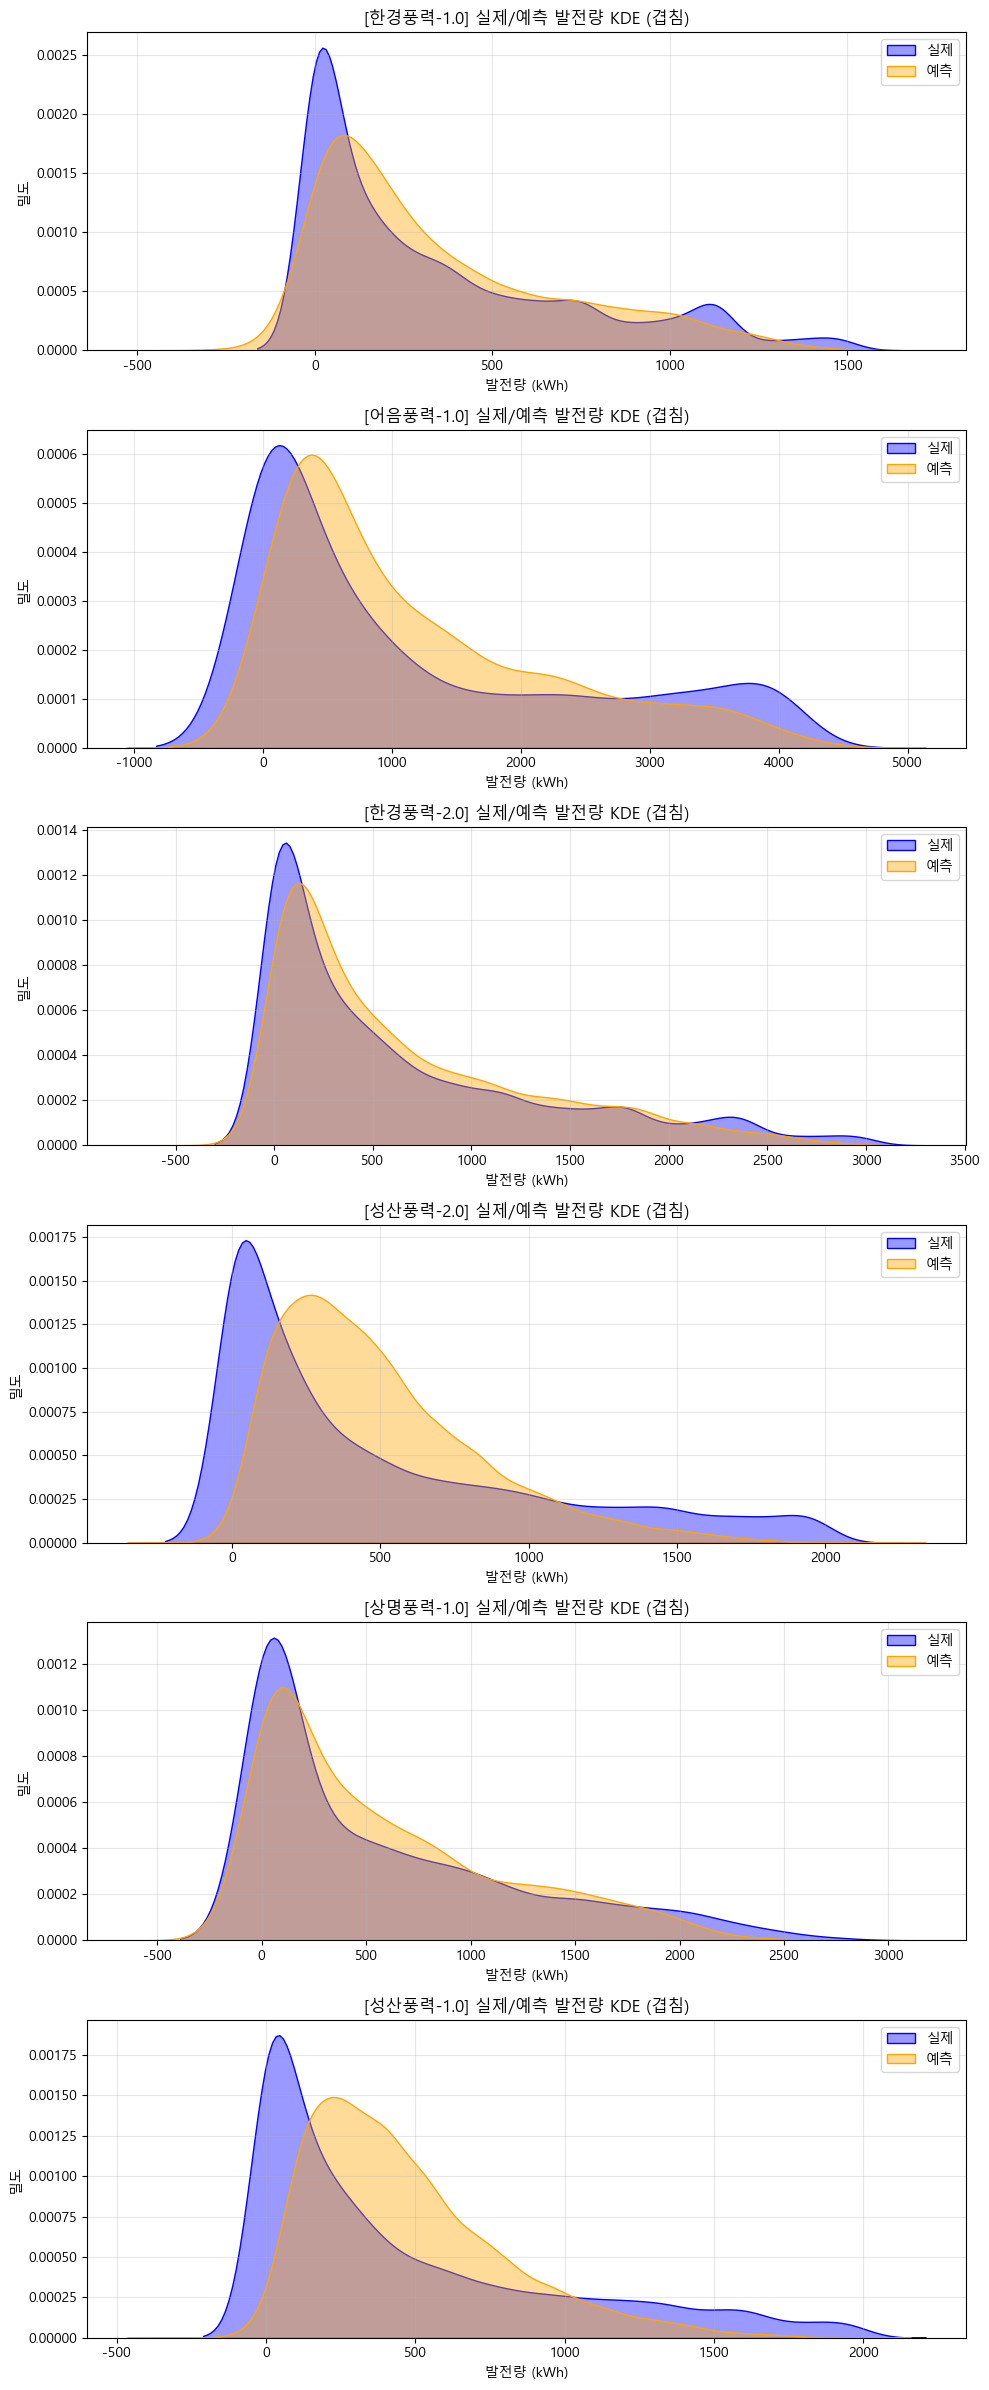

In [18]:

# 발전구분-호기별 실제/예측 발전량 KDE 곡선(겹쳐서, 투명하게)
plant_col = '발전구분' if '발전구분' in df.columns else None
turb_col = None
for col in ['호기', '터빈', '터빈명', '호기명']:
    if col in df.columns:
        turb_col = col
        break
if plant_col is not None and turb_col is not None:
    test_df = X_test.copy()
    test_df['실제'] = y_test.values
    test_df['예측'] = y_pred
    test_df[plant_col] = df.loc[y_test.index, plant_col].values
    test_df[turb_col] = df.loc[y_test.index, turb_col].values
    test_df['조합'] = test_df[plant_col].astype(str) + '-' + test_df[turb_col].astype(str)
    unique_combos = test_df['조합'].unique()
    n_combos = len(unique_combos)
    fig, axes = plt.subplots(n_combos, 1, figsize=(10, 4 * n_combos))
    if n_combos == 1:
        axes = [axes]
    for i, combo in enumerate(unique_combos):
        combo_data = test_df[test_df['조합'] == combo]
        sns.kdeplot(combo_data['실제'], fill=True, ax=axes[i], color='blue', alpha=0.4, label='실제')
        sns.kdeplot(combo_data['예측'], fill=True, ax=axes[i], color='orange', alpha=0.4, label='예측')
        axes[i].set_title(f"[{combo}] 실제/예측 발전량 KDE (겹침)")
        axes[i].set_xlabel('발전량 (kWh)')
        axes[i].set_ylabel('밀도')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()